# Laboration2 - exploring the discrimination lines between bi-variate Gaussian classes

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.special import *

## Some utility functions

In [2]:
# generate n bi-variate gaussian samples with mean (x, y) and standard deviation a along the long axis,
# standard deviation b along the short axis, and angle theta of the long axis counterclockwise from the x-axis
def gen_gauss_data(n, x, y, a, b, theta):
    ct = np.cos(theta*np.pi/180.0)
    st = np.sin(theta*np.pi/180.0)
    mat = np.matrix([[ct, st], [-st, ct]])
    return pd.DataFrame([np.array([random.gauss(0.0, a), random.gauss(0.0, b)]*mat+[x, y])[0] for i in range(n)])

For many parametric distributions the generated data can be characterized by a number of "sufficient statistics". For the distributions we handle here, it is the number of samples, the sums, and the square sums. For simplicity in the calculations we will represent the sufficient statistics for each class as the count of data samples, the mean, and the elements of the (symmetric) covariance matrix. Since we have two-dimensional distributions, this gives 6 numbers per class: n, mu1, mu2, s11, s22, s12.
They are calculated by the following functions:

In [3]:
# calculates the maximum likelihood estimate of the mean vector (mu1, mu2) based on the data in the DataFrame df
def calc_mu(df):
    return (df[0].mean(), df[1].mean())

In [4]:
# claculates the maximum likelihood estimate of the components of the covariance (s11, s22, s12) of the data in df
def calc_sigma(df):
    mu = calc_mu(df)
    s11 = sum((df[0]-mu[0])**2) / len(df)
    s22 = sum((df[1]-mu[1])**2) / len(df)
    s12 = sum((df[0]-mu[0])*(df[1]-mu[1])) / len(df)
    return (s11, s22, s12)

In [5]:
# Returns a 6-tuple with the sufficient statistics of the data in df
def calc_stats(df):
    return (len(df), ) + calc_mu(df) + calc_sigma(df)

The sufficient statistics are also the parameters that define the shapes of the Gaussian and student-t distributions. Below are the probability density functions for bi-variate Gauss and student-t based on those statistics.   

In [6]:
def gauss_2d(x1, x2, stats):
    (n, mu1, mu2, s11, s22, s12) = stats
    det = s11*s22 - s12*s12
    q11 = s22/det
    q22 = s11/det
    q12 = -s12/det
    return np.exp(-(q11*(x1-mu1)*(x1-mu1) + q22*(x2-mu2)*(x2-mu2) + 2*q12*(x1-mu1)*(x2-mu2))/2) / (2*np.pi*np.sqrt(det))

In [7]:
def studentt_2d(x1, x2, stats):
    (n, mu1, mu2, s11, s22, s12) = stats
    mat1 = (n*s11, n*s22, n*s12)
    mat2 = (n/(n+1)*(x1-mu1)*(x1-mu1) + mat1[0], n/(n+1)*(x2-mu2)*(x2-mu2) + mat1[1], n/(n+1)*(x1-mu1)*(x2-mu2) + mat1[2])
    return n*(n-2)/((n+1)*2*np.pi)*(mat1[0]*mat1[1]-mat1[2]*mat1[2])**((n-1)/2) / ((mat2[0]*mat2[1]-mat2[2]*mat2[2])**(n/2))

In [8]:
# Eventually you will need this one too.
# The same as the version above except that it takes the components of the *inverse* covariance Q instead,
# as generated by your sampling
def gauss_2d_mq(x1, x2, params):
    (m1, m2, q11, q22, q12) = params
    det = q11*q22 - q12*q12
    return np.exp(-(q11*(x1-m1)*(x1-m1) + q22*(x2-m2)*(x2-m2) + 2*q12*(x1-m1)*(x2-m2))/2) * np.sqrt(det) / (2 * np.pi)

Below is a function to visualize your results.
It takes a function which it calls for every position in a two-dimensional grid,
and then it shows a colored map as a result.
The function it calls is supposed to take the x and y coordinates, and a parameter object which can contain
any additional parameters the function needs, and is provided in the params parameter to the function below.
Typically these parameters will be either the sufficient statistics of the data, or the sampled posterior parameters.

There is also a function to produce a color scale included below, which is used by the visualization function.

In [9]:
def show_class_distr(func, params, xmin, xmax, ymin, ymax, steps, hue1, hue2):
    fig = plt.figure()
    ax = fig.add_axes((0.0,0.0,1.0,1.0),frame_on=False, xticks=[], yticks=[])
    arr = [[hsl_color((hue1+(hue2-hue1)*func(xmin+(xmax-xmin)*i/steps, ymin+(ymax-ymin)*j/steps, params))%1.0, 1.0, 0.0) for i in range(steps+1)] for j in range(steps+1)]
    im = ax.imshow(arr, origin="lower")

In [10]:
def colorgamma(x):
    if x < 0.0031308:
        return x*12.92
    else:
        return 1.055 * np.power(x, 0.416667) - 0.055

def rgb_color(r, g, b):
    return tuple(list(map(colorgamma, [r,g,b])))

# mimics color.scm with 6color, bluebased, and smooth
def hsl_color(h, s, l):
    hramp = [0, 1/12, 1/6, 1/3, 2/3, 7/9, 1]
    iramp = [(2.410996, 0.16, 0, 0, 1), (0.862552, 0.79, 0, 1, 1),
             (-0.252442, 0.63, 0, 1, 0), (-1.981885, 0.84, 1, 1, 0),
             (1.786451, 0.21, 1, 0, 0), (1.571190, 0.37, 1, 0, 1),
             (2.410996, 0.16, 0, 0, 1)]
    i = 0
    while h > hramp[i+1]:
        i += 1
    p = (h - hramp[i])/(hramp[i+1] - hramp[i])
    (a, br, r, g, b) = tuple(map(lambda x1, x2: p*(x2 - x1) + x1, iramp[i], iramp[i+1]))
    ll0 = (l + 1.0)*0.5
    ll = (np.exp(a*ll0) - 1.0)/(np.exp(a) - 1.0) if not a==0 else ll0
    if ll < br:
        t1 = s * ll / br
        t2 = ll0 * (1.0 - s)
    else:
        t1 = s * (1.0 - ll) / (1.0 - br)
        t2 = ll0 * (1.0 - s) + s * (ll - br) / (1.0 - br)
    return rgb_color(r*t1+t2, g*t1+t2, b*t1+t2)


## Part 1 - classical estimates of Gaussian parameters

This part is simple, since most functions are provided above. All you have to do is to implement the function below, which should use the Bayesian classifier to calculate the probability that a sample with the coordinates (x1, x2) to belong to class one, given the sufficient statistics of the two gaussians provided in params. You can use classical estimates of the class proportion, P(c_k).

(Note that it should calculate the *probability* of class one, as opposed to the final binary classification.)

In [11]:
def func_part1(x1, x2, params):
    (stat1, stat2) = params
    prob1 = gauss_2d(x1, x2, stat1)
    prob2 = gauss_2d(x1, x2, stat2)
    return prob1 / (prob1 + prob2)


Just to check that it works, create synthetic stats, and plot the class regions:

In [12]:
stat1 = (10, -2, 1, 3.0, 3.0, 0.0)
stat2 = (10, 2, -1, 3.0, 3.0, 0.0)

/tmp/ipykernel_29665/556296978.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return prob1 / (prob1 + prob2)


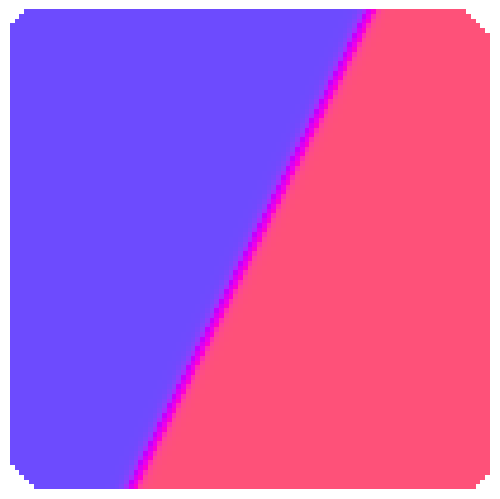

In [13]:
show_class_distr(func_part1, (stat1, stat2), -50, 50, -50, 50, 100, 0.68, 0.98)

If it did work, the above plot should show a nice straight discrimination line.
(The magic numbers 0.68 and 0.98 above represents colors for the visualization, red and blue. It means that probabilities close to zero will come out as red, probabilities close to 1 as blue, and probabilities in between as different shades of purple.)

Then, lets generate some real data and try again:

In [14]:
d1=gen_gauss_data(20, -2, 1, 1.5, 1.5, 0.0)
d2=gen_gauss_data(20, 2, -1, 1.5, 1.5, 0.0)
stat1 = calc_stats(d1)
stat2 = calc_stats(d2)

/tmp/ipykernel_29665/556296978.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return prob1 / (prob1 + prob2)


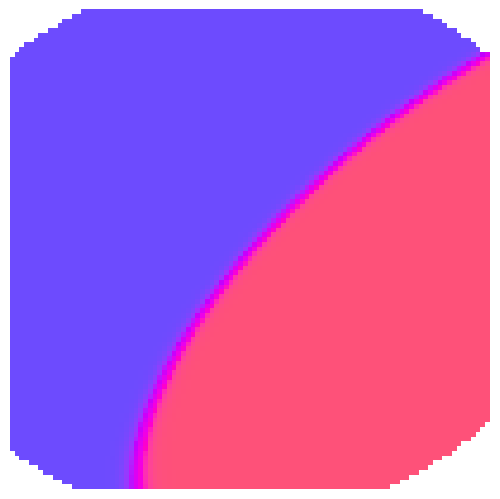

In [15]:
show_class_distr(func_part1, (stat1, stat2), -50, 50, -50, 50, 100, 0.68, 0.98)

Repeat it a couple of times and see what happens? Is it stable? You can play a little with number of data points, or with the other parameters when generating data if you like.

## Part 2 - Bayesian estimation of each distribution

This part is almost as simple. You just have to modify the function slightly to use the predictive distribution of each Gaussian class instead. As shown in the lab instructions, this happens to be a student-t distribution. To be consistent, you should also use Bayesian estimation of the class proportion (not that it matters much for the results in this case).

In [16]:
def func_part2(x1, x2, params):
    (stat1, stat2) = params
    prob1 = studentt_2d(x1, x2, stat1)
    prob2 = studentt_2d(x1, x2, stat2)
    return prob1 / (prob1 + prob2)

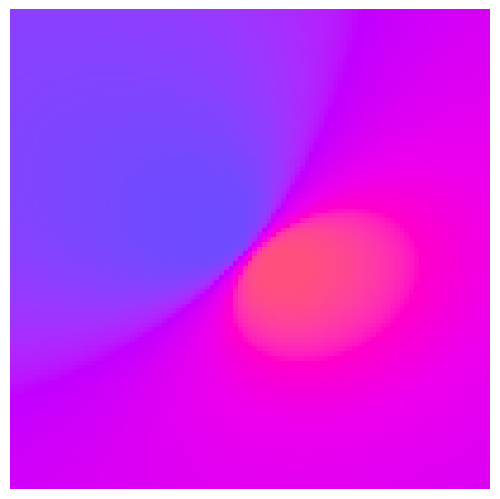

In [17]:
show_class_distr(func_part2, (stat1, stat2), -50, 50, -50, 50, 100, 0.68, 0.98)

What is the different from Part1? Why? 
Try a couple of times with new data generated as above. Stable yet?

### Answer

Just from the plot, the values seems to have a less deterministic result around
the boundaries compared to the part 1. The result of the generation has not 
been stable unless you generate a lot of data. This is highly likely due to
the calculated statistics not matching the actual statistic of the gaussian.

## Part 3 - sampling from the posterior

We are now approaching a full Bayesian treatment of the classification. This requires sampling based integration. 

Drawing samples from a distribution is an art in itself. Even in the simple case of sampling the parameters of a bi-variate Gaussian is rather tricky, and involves solving several integrals. Below we have therefore implemented the sampling for you. Your task will be to implement the numerical integration of an arbitrary function times the posterior, given the sampled parameter values. This is done in the cell at the end of this section.

The sampling in this case is sufficiently simple to make it possible to generate the samples directly from the posterior (after doing the integrals), neither requiring MCMC nor rejection or importance sampling. The function `gen_samples` below generates `num` samples, given the sufficient statistics for the two Gaussians.

There are in total 11 parameters to generate in each sample: First there is the class proportion p. Then there are five parameters from each class: two from the mean vector (m1, m2) and three from the inverse covariance matrix (q11, q22, q12). Each sample is therefore represented as an 11-tuple: (p, m1_1, m1_2, q1_11, q1_22, q1_12, m2_1, m2_2, q2_11, q2_22, q2_12).

In [18]:
# Generate a random class proportion
def gen_classprob(stat1, stat2):
    return betaincinv(stat1[0]-1, stat2[0]-1, random.random())

# Generate the precision of the mean value using a Wishart distribution
def gen_invvar(stat):
    (n, mn1, mn2, s11, s22, s12) = stat
    q22 = gammaincinv((n-1)/2.0, random.random()) / (n*(s22 - s12*s12/s11)/2.0)
    q12 = random.gauss(-s12 * q22/s11, np.sqrt(q22/(n*s11)))
    r1 = gammaincinv(n/2-1, random.random()) * 2 / (n*s11)
    q11 = r1 + q12*q12/q22
    return (q11, q22, q12)

# Genererate a mean value for a bi-variate Gaussian, using the precision above
def gen_mean(stat, par):
    (n, mn1, mn2, s11, s22, s12) = stat
    (q11, q22, q12) = (par[0]*n, par[1]*n, par[2]*n)
    det = q11*q22 - q12*q12
    (c11, c22, c12) = (np.sqrt(q22/det), np.sqrt(1/q22), -q12/np.sqrt(q22*det))
    (r1, r2) = (random.gauss(0,1), random.gauss(0,1))
    (m1, m2) = (r1*c11 + mn1, r1*c12 + r2*c22 + mn2)
    return (m1, m2)

# This function generates one complete sample
def gen_one_sample(stat1, stat2):
    p = gen_classprob(stat1, stat2)
    invvar1 = gen_invvar(stat1)
    mean1 = gen_mean(stat1, invvar1)
    invvar2 = gen_invvar(stat2)
    mean2 = gen_mean(stat2, invvar2)
    return (p,) + mean1 + invvar1 + mean2 + invvar2

# Then a number of samples are generated by repeatedly calling the above function.
def gen_samples(stat1, stat2, num):
    return [gen_one_sample(stat1, stat2) for i in range(num)]

Now you can generate samples of parameters of the posterior distribution given the observed data.
Your task is to implement numerical integration over the posterior distribution, of any function of those parameters.
The function you implement below should take the function to integrate, 'func', as an argument,
and 'func' is as before expected to take the coordinates of a data point (x1, x2) and the posterior parameters 'sample' as arguments. However, this time 'sample' is always the sampled parameters, not the sufficient statistics as before.

In [19]:
# Implement this function for the integration, using the direct sampling approximation. 
def integrate_samples(func, x1, x2, samples):
    items = np.asarray([
        func(x1, x2, sample)
        for sample in samples
    ])
    return np.nanmean(items)

With this function you can use samples from the posterior to approximate the integral of any function times the posterior. This is the way in Bayesian statistics to calculate the answer of any question - the expected value of any entity of interest, over all possible parameter values. This includes the predictive distribution



## Part 4 - performing numerical integration for the predictive distribution

Here we will first verify that the samples are reasonable and the integration function correct by comparing with the results of part 2. Then we will go for the final task of integrating over the Bayesian classifier in part 5.

Lets verify the samples by reproducing the student-t results in part 2. Note that the student-t was arrived at as the predictive distribution of a Gauss distribution, by analytically integrating a Gaussian pdf times the posterior parameter distribution. This is exactly the form of integral you can approximate with your function from part 3, so now you can do the same thing numerically with your samples. 

Fill in the function below, which will be used in show_class_distr in a while. It will have to call integrate_samples three times: one for numerically finding the predictive distribution of the first class (i.e it should become a student-t but we do not assume that here), a second time for the predictive distribution of the second class, and actually a third time for the class proportion to use in the Bayesian classifier. Then return the output of the Bayesian classifier. (Remember that the functions you send to integrate_samples are all expected to have the form func(x1, x2, sample))

Hint 1: Above is defined a function `gauss_2d_mq` which takes the M and Q parameters instead of the sufficient statistics. This is more convenient now since these parameters are provided in the generated samples.
Hint 2: For the class proportion, you just average the generated class proportions in the samples, i.e the first elements of each sample. And calculating an average over the samples is just what `integrate_samples` do.

In [20]:
def func_part4(x1, x2, samples):
    class_proba = integrate_samples(
        lambda x1, x2, sample: sample[0], 
        x1, x2, samples
    )
    param1_proba = integrate_samples(
        lambda x1, x2, sample: gauss_2d_mq(x1, x2, sample[1:6]),
        x1, x2, samples
    ) * class_proba
    param2_proba = integrate_samples(
        lambda x1, x2, sample: gauss_2d_mq(x1, x2, sample[6:11]),
        x1, x2, samples
    ) * (1-class_proba)

    return param1_proba / (param1_proba + param2_proba)

Then generate a suitable bunch of samples

In [21]:
samples = gen_samples(stat1, stat2, 50000)

Then see what it looks like. It should be similar to the result of part 2, if the generated samples were based on the same sufficient statistics as used there. However, this one may take some time.

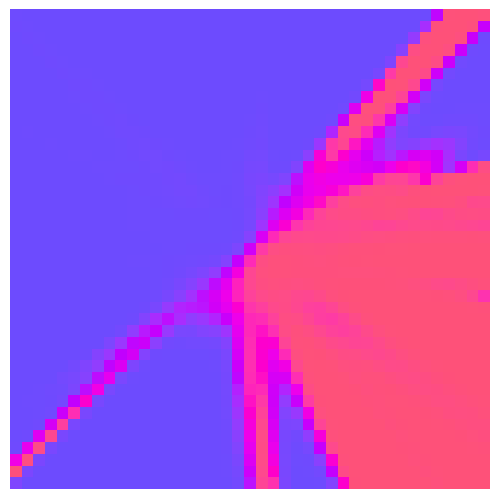

In [22]:
show_class_distr(func_part4, samples, -50, 50, -50, 50, 40, 0.68, 0.98)

### Answer

The result is not exactly the same as the Part 2, but that's because the
calculation is done using sampling and estimation so it's not going to have the
same exact result as the analytical result.

## Part 5 - performing numerical integration for the Bayesian classifier

Finally, fill in the function below, using integrate_samples (only once this time) to integrate the Bayesian classifier expression itself. And check what it looks like when you use it. This may again take some time to evaluate.

Hint: You will need to define a helper function to send to `integrate_samples`, which is the actual Gaussian classifier producing the probability of class 1 at a specific coordinate x1,x2 given a specific parameter sample. Note that it is quite similar to the function you wrote in part 1. Only now the parameters is a sample and not the sufficient statistics, so again you need to make use of `gauss_2d_mq`.

In [23]:
def func_part5(x1, x2, samples):
    def proba(x1, x2, sample):
        p = sample[0]
        params1 = sample[1:6]
        params2 = sample[6:11]
        prob1 = gauss_2d_mq(x1, x2, params1) * p
        prob2 = gauss_2d_mq(x1, x2, params2) * (1-p)
        return prob1 / (prob1 + prob2)
    
    return integrate_samples(proba, x1, x2, samples)


/tmp/ipykernel_29665/2336747340.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return prob1 / (prob1 + prob2)


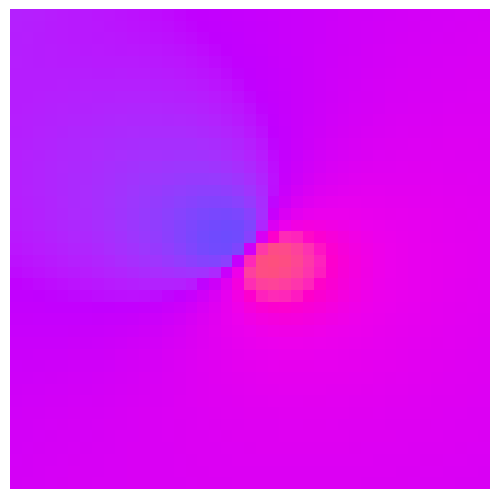

In [24]:
show_class_distr(func_part5, samples, -50, 50, -50, 50, 40, 0.68, 0.98)

You may not want to redo this so many times since it takes some time. However, try at least once more, with a new set generated by `gen_samples`, followed by plotting in the last cell of part 4 and of part 5.

How does the result of part 5 compare to the previous parts? Especially far out from the cluster centers - what does the result tend to there, as opposed to before? Explain how this makes sense.

### Answer

The result far from the cluster centers looks to have had infinity as the
result. This is highly likely due to the numerical stability of the results.
And it looks like removing the errorneous values gave better results.

The result still has a larger band of areas with mixed results compared to the
results of part 2. My guess would be that the results far the cluster centers
are not as stable due to the sampling.
